# Behind the Pipeline

## Recap

Recall the code from Chapter 1

```
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)


[{'label': 'POSITIVE', 'score': 0.9598047137260437},
 {'label': 'NEGATIVE', 'score': 0.9994558095932007}]
```

The pipeline groups 3 steps: 
1. Preprocessing
2. Passing the inputs through the model
3. Postprocessing

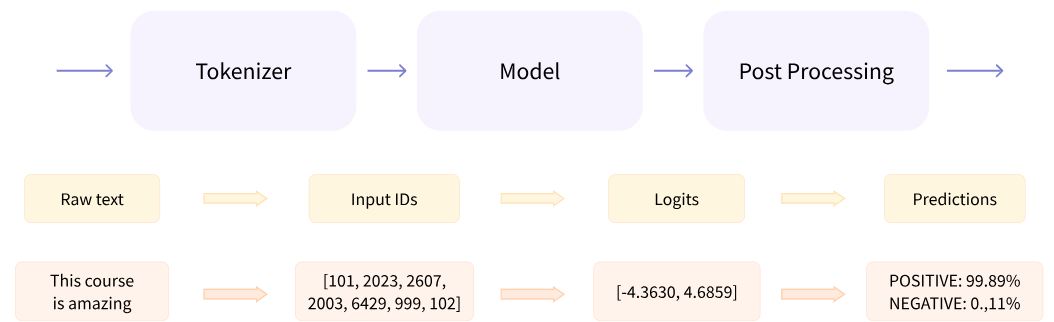

## Step 1: Preprocessing with a tokenizer

Reproducing this step of the pipeline

First step of the pipeline is to convert the raw text inputs into numbers that the model can make sense of.

The ```tokenizer``` is used
- Split intputs into tokens: words, subwords, symbols (like punctuation)
- Map each token to an integer
- Add additional inputs that may be useful to the model

In [1]:
from transformers import AutoTokenizer

"""
To replicate the preprocessing step done in the pipeline, 
we need to do it in the exact same way as when the model (the model in the pipeline) was pretrained

We use the AutoTokenizer class and it's from_pretrained() method to download/fetch the data associated
with the specified model's tokenizer and caches it 

Since the default checkpoint name of the sentiment-analysis pipeline is distilbert-base-uncased-finetuned-sst-2-english,
we pass that to the method

We retrieve the checkpoint model's tokenizer
https://huggingface.co/docs/transformers/v4.15.0/en/model_doc/auto
https://huggingface.co/docs/transformers/v4.15.0/en/model_doc/auto#transformers.AutoTokenizer
Instantiate the model's tokenizer 
"""
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

c:\Users\User\miniconda3\envs\myenv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
"""
We have retrieved the tokenizer from the previous step

We can pass sentences to it and get a dictionary that is ready
to be fed to the model
{
    key: "input_ids",
    value: tensor - 2 rows of integers, one for each sentence that are the unique identifiers of the tokens in each sentence

    key: "attention_mask",
    value: explained later
    }


We can use hugging face transformers w/o worrying about the backend ML framework like PyTorch, Tensorflow etc.
But note that Transformer models only accept tensors as input
Tensors are similar to NumPy arrays 

In the code below, we specify "pt" aka pytorch as the type of return tensor that we want

We can pass one sentence or a list of sentences 
"""

raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


## Step 2: Going through the Model/Passing Inputs through the model

Reproducing this step of the pipeline

In [3]:
"""
Download our specified pretrained model information using the 
from_pretrained() method of the AutoModel class 

https://huggingface.co/docs/transformers/model_doc/auto
https://huggingface.co/docs/transformers/v4.44.0/en/model_doc/auto#transformers.AutoModel

Create a model that is an instance of the specified model 

Downloaded and cache the same checkpoint we used in our pipeline before and instantiated a model with it

This architecture contains only the base Transformer module: 
Given some inputs, it outputs hidden states, also known as features. 
For each model input, we’ll retrieve a high-dimensional vector 
representing the contextual understanding of that input by the Transformer model

These hidden states can be useful on their own, but are usually inputs to another part of the model,
known as the head (last layers focused on the pretraining objective)
- Different tasks can be performed with the same architecture, but each of these tasks
  will have a different head associated with it 
"""

from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### High-Dimensional Vector

The vector output by the Transformer module is usually large. It has 3 dimensions

1. Batch Size: Number of sequences processed at a time (2 in the example above)

2. Sequence Length: Length of the numerical representation of the sequence (16 in the example above)

3. Hidden size: Vector dimension of EACH model input

In [4]:
print("Batch Size: ")
print(len(inputs['input_ids']))
print("")
print("Seq Length: ")
print(len(inputs['input_ids'][0]))
print(len(inputs['input_ids'][1]))
print("Batch Size, Seq Length, Hidden Size")

Batch Size: 
2

Seq Length: 
16
16
Batch Size, Seq Length, Hidden Size


In [5]:
# Feed the inputs we preprocessed to the model
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

"""
Note:

The outputs of transformer models behave like dictionaries

You can access the elements by attributes (as above) or by key
outputs["last_hidden_state"]
or even by index
outputs[0]
"""

torch.Size([2, 16, 768])


'\nNote:\n\nThe outputs of transformer models behave like dictionaries\n\nYou can access the elements by attributes (as above) or by key\noutputs["last_hidden_state"]\nor even by index\noutputs[0]\n'

### Model Heads: Making sense out of the numbers

The output of the Transformer model is sent directly to the model head to be processed.

The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers

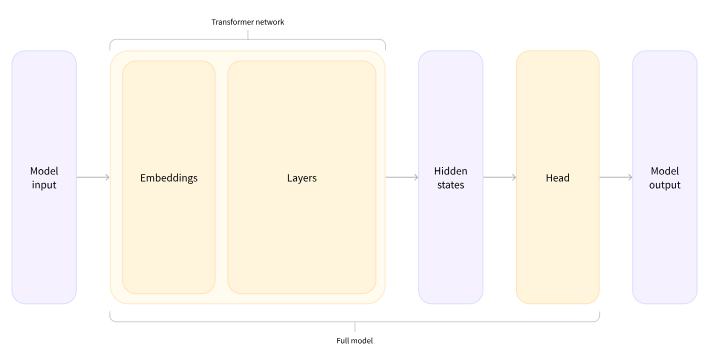

In the diagram above, the model is represented by the embedding and subsequent layers
- Embeddings layer: Converts each input id in the tokenized input (from the tokenizer) into a vector that represents the associated token
- Subsequent layers of the Transformer Network: Manipulate those vectors using the attention mechanism to produce the final representation of the sentences 

In [6]:
"""
For example purposes, we will use a model with a sequence classification HEAD,
to classify sentences as positive or negative 

https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForSequenceClassification

Generic model class that will be instantiated as 
one of the model classes of the library (that you specify) (with a 
sequence classification head) when created with the 
from_pretrained() class method
"""

from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
# note that this is the model + a HEAD 
outputs = model(**inputs)

In [7]:
"""
Recall that we have 2 sentences and 2 labels,
so the result we get from our model is of shape 2x2
"""
print("Shape of the outputs of the sequence classification model:")
print(outputs.logits.shape)

Shape of the outputs of the sequence classification model:
torch.Size([2, 2])


## Step 3: Postprocessing the Output

In [8]:
"""
The values we get as output from our model don't really make sense by themselves
"""

print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


The model predicted ```[-1.5607, 1.6123]``` for the first sentence
The model predicted ```[ 4.1692, -3.3464]``` for the second sentence

These are not probabilities. They are ```logits```: raw, unnormalized scores output by the last layer of the model

To convert the ```logits``` to ```probabilities```, they need to go through a ```SoftMax``` layer 
- The softmax function, also known as softargmax converts a vector of K real numbers into a probability distribution of K possible outcomes

Note: All hugging face transformers models output logits 


In [9]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


Now we can see that the model predicted [0.0402, 0.9598] for the first sentence and [0.9995, 0.0005] for the second one. These are recognizable probability scores

In [10]:
"""
To get the labels corresponding to each position, we can inspect the id2label attribute of the model config
"""
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Therefore, we can conclude that the model predicted the following:
- First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
- Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005

We have successfully reproduced the three steps of the pipeline: 
1. preprocessing with tokenizers
2. passing the inputs through the model
3. postprocessing